In [1]:
# -*- coding: utf-8 -*-
###############################################################################

# This notebook implements the plots in the Chapter 5.1 of the paper.  
# https://arxiv.org/pdf/1007.1727v3.pdf

# Author: Haoran Zhao
# Email: hrzhao76 AT gmail.com
###############################################################################

In [2]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from tqdm import tqdm
import hist
import mplhep
from typing import Union

mplhep.style.use(mplhep.style.ATLAS)

np.random.seed(42)

# Figure 3(a)

In [3]:
def Likelihood(
    n: Union[int, np.array],
    m: Union[int, np.array],
    b: int,
    mu: float,
    s: int = 10,
    tau: float = 1,
) -> Union[float, np.array]:
    """The Likelihood function for the Counting experiment, eqn 90. 

    Args:
        n (Union[int, np.array]): Observed number of events. 
        m (Union[int, np.array]): Control sample help to constrain the nuisance parameter b.
        b (int): Expected number from background processes.
        mu (float): Signal strength.
        s (int, optional): Expected number of signal events. Defaults to 10.
        tau (float, optional): Scale factor. Defaults to 1.

    Returns:
        Union[float, np.array]: The likelihood function.
    """
    poisson_sig = stats.poisson.pmf(mu=mu * s + b, k=n)
    poisson_bkg = stats.poisson.pmf(mu=tau * b, k=m)
    return poisson_sig * poisson_bkg


def MLE_mu_hat(
    n: Union[int, np.array],
    m: Union[int, np.array],
    s: int = 10,
    tau: float = 1,
) -> Union[float, np.array]:
    """Maximum likelihood estimator of mu, eqn 91.

    Args:
        n (Union[int, np.array]): Observed number of events.
        m (Union[int, np.array]): Control sample help to constrain the nuisance parameter b.
        s (int, optional): Expected number of signal events. Defaults to 10.
        tau (float, optional): Scale factor. Defaults to 1.

    Returns:
        Union[float, np.array]: The MLE of mu.
    """
    return (n - m / tau) / (s)

def MLE_b_hat(
    m: Union[int, np.array],
    tau: float = 1,
) -> Union[float, np.array]:
    """Maximum likelihood estimator of b, eqn 92.

    Args:
        m (Union[int, np.array]): _description_
        tau (float, optional): _description_. Defaults to 1.

    Returns:
        Union[float, np.array]: _description_
    """
    return m / tau


def MLE_b_hat_hat(
    n: Union[int, np.array],
    m: Union[int, np.array],
    mu: float,
    s: int,
    tau: float = 1,
) -> Union[float, np.array]:

    a = tau * (tau + 1)
    b = tau * (mu * s + tau * mu * s - m - n)
    c = -m * tau * mu * s

    return (-b + np.sqrt(b**2 - 4 * a * c)) / (2 * a)


def Lambda_mu(
    n: Union[int, np.array], m: Union[int, np.array], mu: float, s: int, tau: float = 1
) -> Union[float, np.array]:
    profiled_likelihood = Likelihood(n=n, m=m, mu=mu, b=MLE_b_hat_hat(n, m, mu, s))
    unconditional_likelihood = Likelihood(n=n, m=m, mu=MLE_mu_hat(n, m), b=MLE_b_hat(m))
    return profiled_likelihood / unconditional_likelihood


def Get_q0(
    n: Union[int, np.array], m: Union[int, np.array], mu: float, s: int, tau: float = 1
):
    mu_hat = MLE_mu_hat(n=n, m=m, tau=tau)
    neg_index = mu_hat < 0

    lambda_mu = Lambda_mu(n=n, m=m, mu=mu, s=s)
    lambda_mu[neg_index] = 1
    q0 = -2 * np.log(lambda_mu)

    return q0

In [4]:
def f_q0(q0: Union[float, np.array]) -> Union[float, np.array]:
    """pdf of q0 given mu_prime=0, eqn 49.

    Args:
        q0 (Union[float, np.array]): Test statistic q0 for discovery. 

    Returns:
        Union[float, np.array]: pdf of q0.
    """
    return 1 / 2 * 1 / np.sqrt(2 * np.pi) * 1 / np.sqrt(q0) * np.exp(-q0 / 2)


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:13<00:00,  3.49s/it]


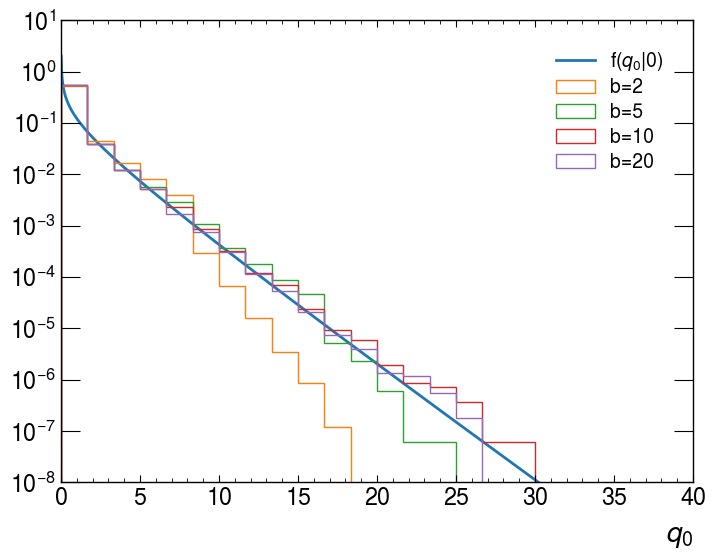

In [5]:
s = 10  # number of signal events
tau = 1 # scale factor, general unknown.

x_s = np.linspace(0.01, 40, 3001)

fig, ax = plt.subplots(figsize=(8, 6))
f_q0_x = f_q0(q0=x_s)
ax.plot(x_s, f_q0_x, label=r"f($q_0$|0)")
ax.set_yscale("log")
ax.set_ylim(1e-8, 10)
ax.set_yticks([10, 1] + [1 / 10**i for i in range(1, 9)])

ax.set_xlabel(r"$q_0$")


b_s = [2, 5, 10, 20]
mu = 0
N_trails = 10000000
for b in tqdm(b_s):
    n_s = stats.poisson.rvs(mu=mu * s + b, size=N_trails)
    m_s = stats.poisson.rvs(mu=tau * b, size=N_trails)
    q0_s = Get_q0(n=n_s, m=m_s, mu=mu, s=s)
    ax.hist(q0_s, bins=24, range=(0, 40), density=True, histtype="step", label=f"b={b}")

ax.legend()
plt.show()

# Figure 3(b)

In [22]:
s = 10
b = 10
tau = 1

In [ ]:
def f_q0_muprime(q0: Union[float, np.array], mu_prime: float, sigma: float) -> Union[float, np.array]:
    """pdf of q0 given mu_prime, eqn 48.

    Args:
        q0 (Union[float, np.array]): Test statistic q0 for discovery. 
        mu_prime (float): The signal strength.

    Returns:
        Union[float, np.array]: pdf of q0.
    """


    1 / 2 * 1 / np.sqrt(2 * np.pi) * 1 / np.sqrt(q0) * np.exp(-(np.sqrt(q0) - mu_prime / sigma)**2 / 2)

    return 0

In [30]:
def f_q0_mup(q0, mup=1):
    """Asymptotic distribution of q0"""
    q_0_A = -2 * np.log(calculate_q0(n=mup * s + b, m=tau * b, mu=mup))
    sigma = np.sqrt(mup**2 / q_0_A)
    return (
        1
        / 2
        * 1
        / np.sqrt(2 * np.pi)
        * 1
        / np.sqrt(q0)
        * np.exp(-1 / 2 * (q0 - mup / sigma) ** 2)
    )

/var/folders/l8/k4rv8vgs70nfv0kfc2d39n200000gn/T/ipykernel_43172/1390112738.py:9: RuntimeWarning: divide by zero encountered in divide
  return 1/2 * 1/np.sqrt(2*np.pi) *  1/np.sqrt(q0) * np.exp(-q0/2)
/var/folders/l8/k4rv8vgs70nfv0kfc2d39n200000gn/T/ipykernel_43172/3332193525.py:5: RuntimeWarning: divide by zero encountered in divide
  return 1/2 * 1/np.sqrt(2*np.pi) *  1/np.sqrt(q0) * np.exp(-1/2 *(q0 - mup / sigma)**2)


(1e-08, 10)

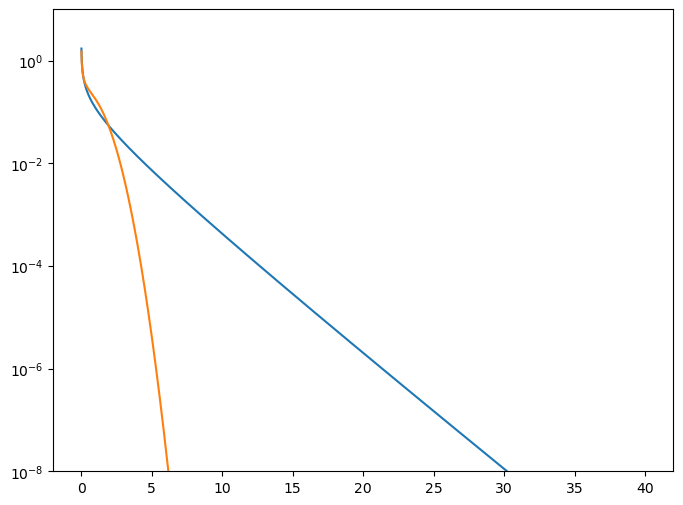

In [32]:
x_s = np.linspace(0, 40, 3001)

fig, ax = plt.subplots(figsize=(8, 6))
f_q0_x = f_q0(q0=x_s)
f_q0_mup_x = f_q0_mup(q0=x_s, mup=1)

ax.plot(x_s, f_q0_x, label=r"f($q_0$|0)")
ax.plot(x_s, f_q0_mup_x, label=r"f($q_0$|1)")
ax.set_yscale("log")
ax.set_ylim(1e-8, 10)

# DeV 

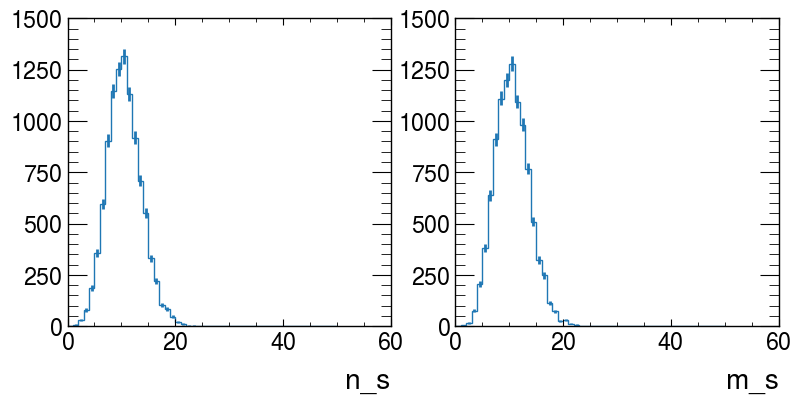

In [13]:
# N_trails = 100000000
N_trails = 10000
mu = 0
s = 10
b = 10
tau = 1

n_s = stats.poisson.rvs(mu=mu * s + b, size=N_trails)
m_s = stats.poisson.rvs(mu=tau * b, size=N_trails)

n_bins = 50
hist_2d = hist.Hist(
    hist.axis.Regular(n_bins, 0, n_bins, name="n_s"),
    hist.axis.Regular(n_bins, 0, n_bins, name="m_s"),
)

hist_2d.fill(n_s, m_s)


fig, axs = plt.subplots(1, 2, figsize=(9, 4))
mplhep.histplot(hist_2d.project("n_s"), label="n_s", ax=axs[0])
mplhep.histplot(hist_2d.project("m_s"), label="m_s", ax=axs[1])
plt.show()